# MCMC for the mass distribution of EMRIs

Choose whether you want to include selection effects in the analysis.

In [1]:
selection_effects = True # Select True if you want to complicate your life.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We fit a BH mass functionsource parameter given by the mass, $\theta=M$. This example follows the EMRI mass function [e-Print: 1004.1921 ("GTV")]:

$$\frac{dN}{d\ln M}=A_0\big(\frac{M}{M_*}\big)^{\alpha_0} \quad\Rightarrow\quad p(M|\lambda)=\mathcal{N} M^{\alpha_0-1} = \frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}} M^{\alpha_0-1}.$$

We are interested in the $ \lambda=\alpha_0$ population parameter. We are assuming that the amplitude $A_0$ does not carry information about the system, but only about the rate of events.

In [3]:
def model(lnM,alpha):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data    (The noisy generated data where we expect the masses to be.)
    - alpha   (Spectral index of the mass distribution.)
    
    """
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    
    return norm*M**(alpha-1)

In [4]:
"""
Parameters
"""

N_obs = 100
N_samps_likelihoods = 10
N_samps_selfunction = 100000 # Needs to be high to sample well the selection function's integral.


alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min) # M runs from 10^4
M_max=10000000.; logM_max = np.log(M_max) # to 10^7 solar masses.


Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

In [5]:
def log_M(alpha, N, Mmax,Mmin):

    """
    Analytical function to draw samples following a power law. 
    It helps in the definition of the selection function for the MCMC analysis.
    
    Inputs:
    
    - alpha: the spectral index chosen.
    - N: the number of events of the true underlying population.
    - Mmax, Mmin: limits of integration, the minimum and maximum mass of underlying pop.
    
    """
    
    return alpha**-1 * np.log((Mmax**(alpha)-Mmin**(alpha))*np.random.uniform(size=N)+ Mmin**(alpha)*np.ones(N))

In [6]:
"""
Noise characteristics.
"""

sigma = 0.1
dth = 13.0
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=log_M(alpha0_t, N_obs, M_max,M_min)
d_i = noise + logM_t  # observation model made of noise + true population.
d_i_selbias = d_i[d_i>dth]
N_det = len(d_i_selbias)

if selection_effects==True: print('Out of', N_obs,'possible events,', N_det,'are detected.')

"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian with noise variance sigma.

"""

logM_obs=np.zeros((N_obs,N_samps_likelihoods))
logM_obs_selbias=np.zeros((N_det,N_samps_likelihoods))

for i in np.arange(N_obs):
    logM_obs[i,:]=np.random.normal(d_i[i],sigma,size=N_samps_likelihoods)
for i in np.arange(N_det):
    logM_obs_selbias[i,:]=np.random.normal(d_i_selbias[i],sigma,size=N_samps_likelihoods)
    
if selection_effects == True: 
    data = logM_obs_selbias
else:
    data =logM_obs

Out of 100 possible events, 47 are detected.


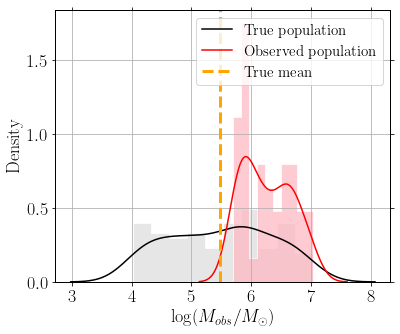

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='gainsboro', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='k')

if selection_effects==True:
    plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                               color ='lightpink', alpha=0.7, edgecolor='white')
    sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='red')
    
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

In [8]:
from scipy.special import erfc

# Limits of (flat) hyperpriors.

hyperprior_min = -10.0
hyperprior_max = 10.0


def selection_function(Lambda,number_samples_for_integration,upper_limit,lower_limit,noise_var,threshold):
    
    """
    This function is redefined in such a way that the hyperparameter appears as an input.
    One must generate samples at each iteration of lambda in the MCMC.
    """
    theta_ij = log_M(Lambda,number_samples_for_integration,upper_limit,lower_limit)
    
    return np.sum(0.5*erfc((threshold-theta_ij)/np.sqrt(2)/noise_var))/number_samples_for_integration

def log_likelihood(params, data):
    
    """
    Support.
    """
     
    support = ( # Here is the support limits for hyperpriors.
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
    
    log_likelihood=0

    """
    Selection function.
    """
    
    if selection_effects == True:
        pdet = selection_function(params[0],N_samps_selfunction,M_max,M_min,sigma,dth)
        Nsources = N_det
    else: 
        pdet = 1.
        Nsources = N_obs
    
    """
    Population likelihood.
    """

    for i in np.arange(Nsources):
        
        ppop_ij = model(data[i,:],params[0])           # N_samp-long array for population model.
        sum_ppop = np.sum(ppop_ij)                     # Internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop/pdet)        # Add the samples drawn over N_obs in the loop
                                                       # and divide by the selection function at each step.
    
    
    """
    Output without infinities and within the specified hyperpriors.
    """
    out = np.where(support,log_likelihood,-np.inf)     # Only retain likelihood if supported.
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [9]:
n_iter = 10000
ndim = 1; nwalkers = 2

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 10000/10000 [01:23<00:00, 119.28it/s]


In [10]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

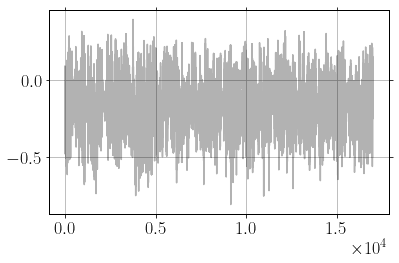

In [11]:
plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

### Fisher estimates

In both the case with and without selection effects the Fisher estimate is dominated by the first term in the integral, which from the paper reads

$$
(\Gamma_\lambda)_{ij} \approx -\int \frac{\partial^2 \ln (p(\theta | \lambda)/p_{\rm det}(\lambda))}{\partial\lambda^i \partial\lambda^j} \, \frac{p_{\rm det}(\theta)}{p_{\rm det}(\lambda)} p(\theta |\lambda) {\rm d} \theta.
$$

In the simplifying case in which there are no selection effects, the estimate is analytically found to be (see $\texttt{Mathematica}$ notebook)

$$
\Gamma_\alpha \approx N_\text{obs}\left(\frac{1}{\alpha^2}-\frac{M_\text{max}^\alpha M_\text{min}^\alpha (\ln M_\text{max}-\ln M_\text{min})^2}{(M_\text{max}^\alpha-M_\text{min}^\alpha)^2}\right)
$$

In [12]:
# Estimates without selection effects.

def Dalpha(Nobs,alpha,Mmin,Mmax):
    """
    This expression is only valid for 1D fitting, and crucially it only accounts for the first 
    term in the FM. More accurate estimates can be obtained with the accompanying Mathematica 
    notebook.
    """
    den = Nobs * (alpha**-2 - (Mmax**alpha * Mmin**alpha * np.log(Mmax/Mmin)**2)/(Mmax**alpha-Mmin**alpha)**2)
    return np.sqrt(1/den)

def gaussian(d,mu,Sigma_sq): 
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

In the case without selection effects, we model all terms in the Fisher matrix for extra sense of security.

We solve the integral with the Monte Carlo method, implying that we only focus on the arguments $X(\theta)$ of integrals of the form
$$
\int X(\theta) p(\theta|\lambda) d\theta \approx \frac{1}{N_\text{samp}}\sum X(\theta_{ij}), \quad \text{with } \theta_{ij}\sim p(\theta|\lambda)
$$
For the first term, the argument is
$$
-\frac{\partial^2 \ln (p(\theta | \lambda)/p_{\rm det}(\lambda))}{\partial\lambda^i \partial\lambda^j} \, \frac{p_{\rm det}(\theta)}{p_{\rm det}(\lambda)},
$$
where we further use that (with primes indicating derivatives wrt $\lambda$)
$$
-\frac{\partial^2 \ln (p(\vec\theta_0 | \vec\lambda)/p_{\rm det,m}(\vec\lambda))}{\partial\lambda^i \partial\lambda^j} = \frac{p'(\theta|\lambda)^2 -p(\theta|\lambda)p''(\theta|\lambda)}{p(\theta|\lambda)^2} + \frac{p_\text{det}(\lambda)p''_\text{det}(\lambda)-p'_\text{det}(\lambda)^2}{p_\text{det}(\lambda)^2}.
$$

The derivatives $p'(\theta|\lambda)$ and $p''(\theta|\lambda)$ can be calculated analytically (see Mathematica notebook). We code those expressions below. 

In [13]:
# Derivatives of population model

def dppop_dlambda(theta, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):  

    norm= theta_max**Lambda -theta_min**Lambda
    num = np.exp(theta)**(Lambda-1) * (norm+norm*Lambda*theta-theta_max**Lambda*Lambda*np.log(theta_max)+ theta_min**Lambda*Lambda*np.log(theta_min))
    den = norm**2
    return num/den

def ddppop_ddlambda(theta, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):  

    norm = theta_max**Lambda -theta_min**Lambda
    num_1 = theta_max**(2*Lambda)*(theta-np.log(theta_max))*(2+Lambda*theta-Lambda* np.log(theta_max))
    num_2 = theta_min**(2*Lambda)*(theta-np.log(theta_min))*(2+Lambda*theta-Lambda* np.log(theta_min))
    num_3 = theta_max**(Lambda)*theta_min**(Lambda)*(-2*Lambda*theta**2+2*(np.log(theta_max)+np.log(theta_min))+Lambda*(np.log(theta_max)**2-4*np.log(theta_max)*np.log(theta_min)+np.log(theta_min)**2)+2*theta*(-2+Lambda*(np.log(theta_max)+np.log(theta_min))))
    num = num_1 +num_2 + num_3
    den = norm**3
    return np.exp(theta)**(Lambda-1)*num/den

We also need the expressions for the selection functions of $\lambda$ and $\theta$, 
$$
p_\text{det}(\theta) =  \frac{1}{2}\text{erfc}\left[\frac{d_\text{th}-\theta}{\sqrt{2}\sigma}\right], \quad
p_\text{det}(\lambda) = \int p_\text{det}(\theta) p(\theta|\lambda) d\theta \approx \frac{1}{N_\text{samp}}\sum \frac{1}{2}\text{erfc}\left[\frac{d_\text{th}-\theta_{ij}}{\sqrt{2}\sigma}\right] (\text{with } \theta_{ij}\sim p(\theta|\lambda)).
$$

The first and second derivatives of $p_\text{det}(\lambda)$ can be integrated in the same way using that

$$
\frac{\partial p_\text{det}(\lambda)}{\partial \lambda} = \int p_\text{det}(\theta) \frac{\partial p(\theta|\lambda)}{\partial \lambda} d\theta = \int p_\text{det}(\theta) \frac{\partial \ln p(\theta|\lambda)}{\partial \lambda}p(\theta|\lambda) d\theta
$$
and 
$$
\frac{\partial^2 p_\text{det}(\lambda)}{\partial \lambda^2} = \int p_\text{det}(\theta) \frac{\partial^2 p(\theta|\lambda)}{\partial \lambda^2} d\theta = \int p_\text{det}(\theta) \left[\frac{\partial^2 \ln p(\theta|\lambda)}{\partial \lambda^2}+\left(\frac{\partial \ln p(\theta|\lambda)}{\partial \lambda}\right)^2\right]p(\theta|\lambda) d\theta
$$

The derivatives of $\ln p(\theta|\lambda)$, coded below, are obtained using $\texttt{Mathematica}$.

In [14]:
# Selection function and derivatives.

def pdet_lambda(theta_samples): 
    return 0.5*N_samps_selfunction**-1*np.sum(erfc((dth-theta_samples)/np.sqrt(2)/sigma))
def pdet_theta(theta): 
    return 0.5* erfc((dth-theta)/np.sqrt(2)/sigma)

def dpdet_dlambda(theta_samples, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):     
    """
    Obtained as outlined above with derivatives of p(theta|lambda) from Mathematica.
    """
    norm = theta_max**Lambda -theta_min**Lambda
    num = norm + norm*Lambda*theta_samples - theta_max**Lambda * Lambda * np.log(theta_max) + theta_min**Lambda* Lambda * np.log(theta_min)
    den = norm * Lambda
    
    arg = pdet_theta(theta_samples) * num/den
    
    return N_samps_selfunction**-1*np.sum(arg)  

def ddpdet_ddlambda(theta_samples, Lambda =alpha0_t,theta_min=M_min,theta_max =M_max):  
    """
    Obtained as outlined above with derivatives of p(theta|lambda) from Mathematica.
    """
    norm = theta_max**Lambda -theta_min**Lambda
    num_1 = - norm**2 + theta_max**Lambda * theta_min**Lambda * Lambda**2 * np.log(theta_max)**2 - 2*theta_max**Lambda * theta_min**Lambda * Lambda**2 * np.log(theta_max)*np.log(theta_min) + theta_max**Lambda * theta_min**Lambda * Lambda**2 * np.log(theta_min)**2
    den_1 = norm**2 * Lambda**2
    num_2 = norm + norm*Lambda*theta_samples - theta_max**Lambda * Lambda * np.log(theta_max) + theta_min**Lambda* Lambda * np.log(theta_min)
    den_2 = norm * Lambda
    
    arg = pdet_theta(theta_samples) * (num_1/den_1 + (num_2/den_2)**2)
    
    return N_samps_selfunction**-1*np.sum(arg) 

The results above are enough to obtain the simplified version of the Fisher matrix, which only retains the first term.

In [32]:
# Final expression for the Fisher matrix

def Gamma_lambda(theta_samples,Lambda =alpha0_t):

    
    ppop = model(theta_samples,Lambda)
    
    #Various terms of the Fisher matrix, as calculated above and in the Mathematica notebook.
    Gamma_1_term = ((dppop_dlambda(theta_samples)**2-ppop*ddppop_ddlambda(theta_samples))/ppop**2 + (pdet_lambda(theta_samples)*ddpdet_ddlambda(theta_samples)-dpdet_dlambda(theta_samples)**2)/pdet_lambda(theta_samples)**2)* pdet_theta(theta_samples)/pdet_lambda(theta_samples)
    
    
    # Integral calculated here.
    # Notice that the normalization is over the number of detected events.
    
    Gamma_tot = Gamma_1_term
    integral = N_samps_selfunction**-1*np.sum(N_det *Gamma_tot)
    
    return integral

In [35]:
#samples drawn from PDF to be used in the Monte Carlo integral.
theta_ij = log_M(alpha0_t,N_samps_selfunction,M_max,M_min) 


print('First derivative pdet:', dpdet_dlambda(theta_ij)) # must be a number
print('Second derivative pdet:', ddpdet_ddlambda(theta_ij))# must be a number
print('First derivative ppop:', dppop_dlambda(theta_ij))# must be an array
print('Second derivative ppop:', ddppop_ddlambda(theta_ij))# must be an array


print('Gamma_lambda:', Gamma_lambda(theta_ij))

First derivative pdet: 0.8510037610557877
Second derivative pdet: 0.16773143871134458
First derivative ppop: [-4.23147060e-06 -8.58547146e-06  5.07844551e-08 ... -1.28718460e-05
  5.32929802e-08  7.71370949e-08]
Second derivative ppop: [-2.92531741e-06  2.80944917e-06  1.15102541e-07 ...  9.80402630e-06
  1.15575888e-07  1.12134632e-07]
Gamma_lambda: 34.3474189763179


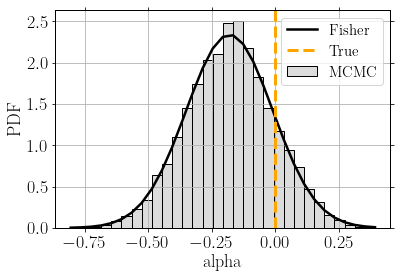

In [36]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar', color ='gainsboro', density=True, edgecolor='black', label='MCMC')
bins_alpha= np.array(bins_alpha)

if selection_effects == False: 
    
    # Fisher estimate without selection effects.
    Da = Dalpha(N_obs,alpha0_t,M_min,M_max)
    plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t,Da**2), color='black', lw=2.5,label='Fisher')
    
else:
    Da=np.sqrt(1/Gamma_lambda(theta_ij))#dalpha_v1(logM_t,alpha0_t)
    plt.plot(bins_alpha, gaussian(bins_alpha,alpha0_t-0.18,Da**2), color='black', lw=2.5,label='Fisher')
    

plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()